In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import altair as alt
from scipy import stats
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf

alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype');

### Read Data

In [2]:
with open("config.yaml", "r") as config_file:
    config = yaml.full_load(config_file)
    data_path = config["data_path"]
    models_path = config["models_path"]

In [3]:
inventory_df = pd.read_csv(os.path.join(data_path, "preprocessed_data.csv"))[["dt", "inventory", "units"]]
inventory_df["dt"] = pd.to_datetime(inventory_df["dt"])
inventory_df.head(3)

,dt,inventory,units
0,2017-09-26,693,36
1,2017-09-27,673,34
2,2017-09-28,626,33


### EDA

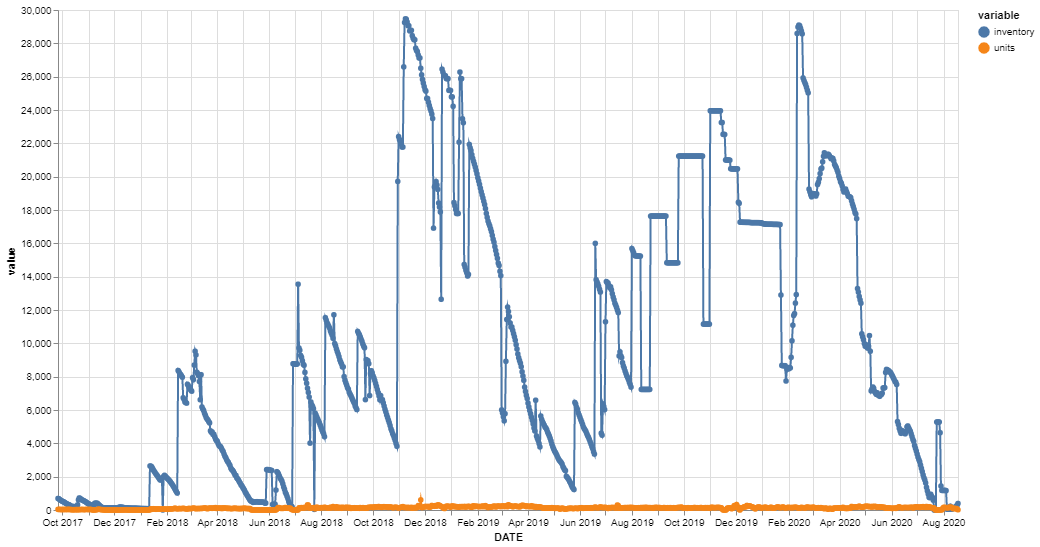

In [4]:
alt.Chart(pd.melt(inventory_df, "dt")).mark_line(point=True).encode(
    x=alt.X('dt:T', axis = alt.Axis(title = 'Date'.upper(), format = ("%b %Y"))),
    y=alt.Y('value:Q', scale=alt.Scale(zero=False)),
    color=alt.Color("variable:N")
).properties(width=900, height=500)

In [5]:
inventory_df["new_inventory"] = inventory_df["inventory"] - (inventory_df["inventory"].shift(1) - inventory_df["units"].shift(1))

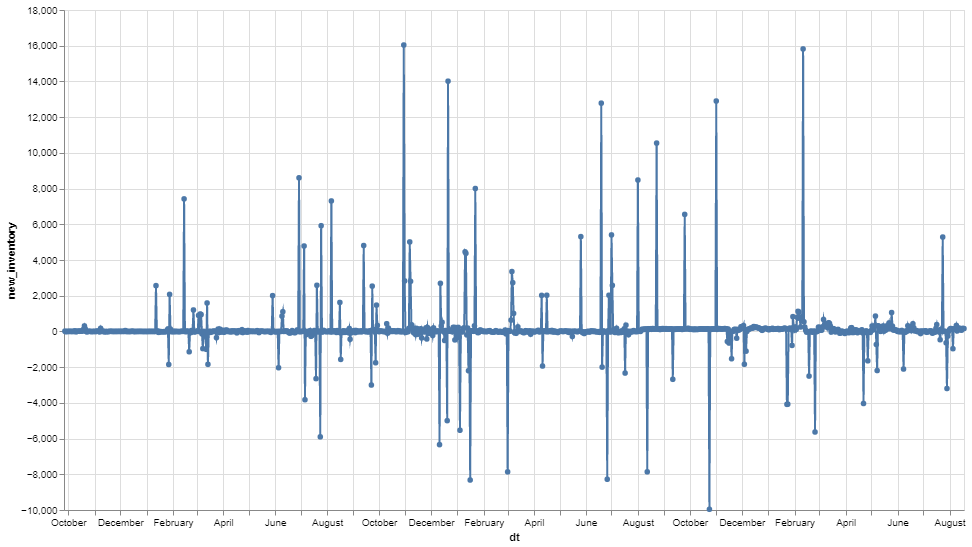

In [6]:
alt.Chart(inventory_df).mark_line(point=True).encode(
    x=alt.X('dt:T'),
    y=alt.Y('new_inventory:Q', scale=alt.Scale(zero=False)),
).properties(width=900, height=500)

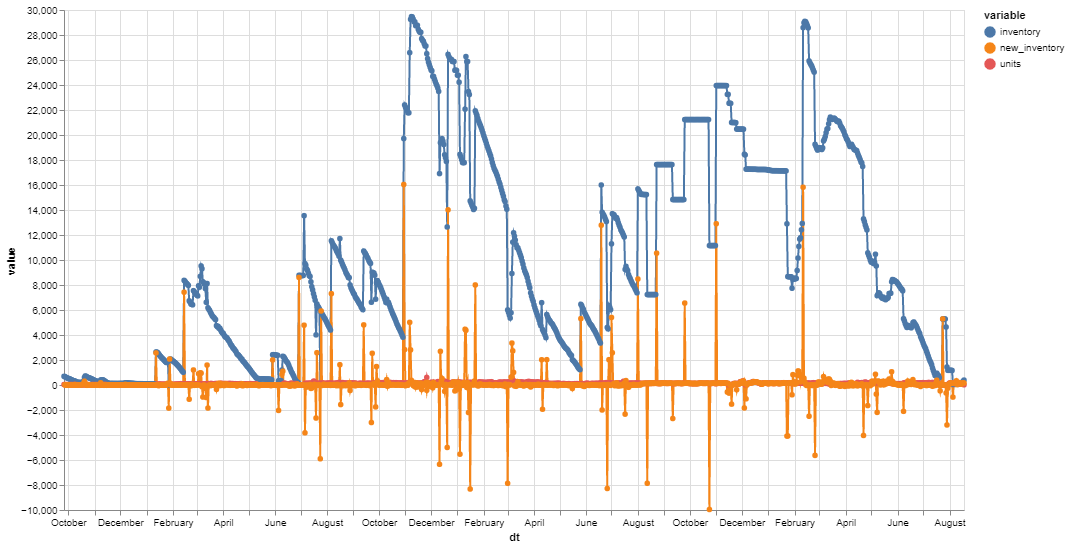

In [7]:
alt.Chart(pd.melt(inventory_df, "dt")).mark_line(point=True).encode(
    x=alt.X('dt:T'),
    y=alt.Y('value:Q', scale=alt.Scale(zero=False)),
    color=alt.Color("variable:N")
).properties(width=900, height=500)

C:\Users\andrii.prysiazhnyk\AppData\Local\Continuum\anaconda3\envs\amazon_pricing\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


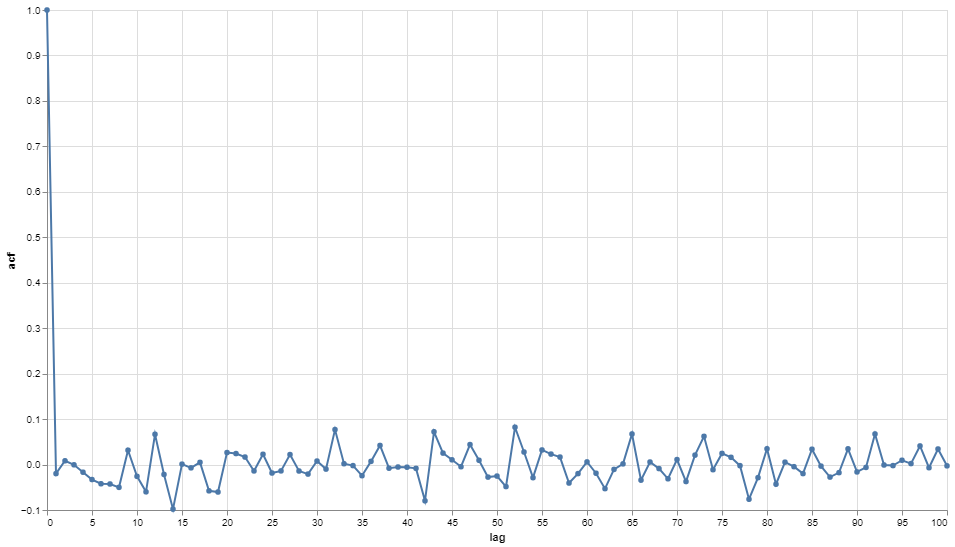

In [8]:
nlags = 100
acf_df = pd.DataFrame({"lag": range(nlags + 1), "acf": acf(inventory_df["new_inventory"].dropna(), nlags=nlags)})
alt.Chart(acf_df).mark_line(point=True).encode(
    x=alt.X('lag:Q'),
    y=alt.Y('acf:Q'),
).properties(width=900, height=500)

In [9]:
threshold = 4000
filtered_df = inventory_df[inventory_df["new_inventory"] > threshold]
filtered_df["days_interval"] = (filtered_df["dt"] - filtered_df["dt"].shift(1)).apply(lambda x: x.days)
filtered_df["day"] = filtered_df["dt"].apply(lambda x: x.day)

C:\Users\andrii.prysiazhnyk\AppData\Local\Continuum\anaconda3\envs\amazon_pricing\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andrii.prysiazhnyk\AppData\Local\Continuum\anaconda3\envs\amazon_pricing\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


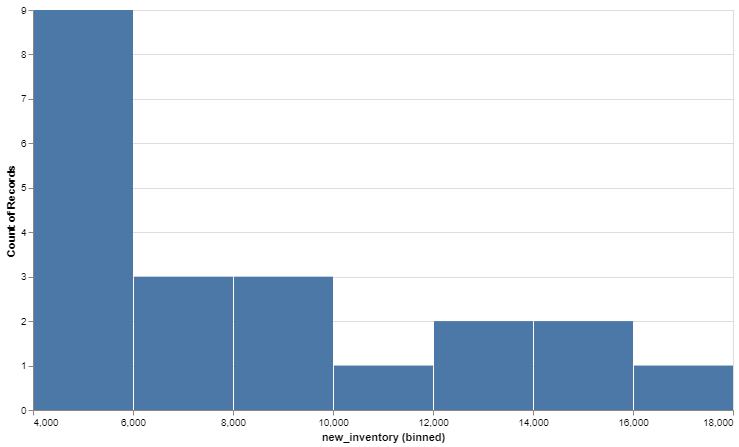

In [10]:
histogram = alt.Chart(filtered_df).mark_bar(point=True) \
.encode(
    x = alt.X("new_inventory:Q", bin=alt.Bin(maxbins=10)),
    y = alt.Y("count()"),
).properties(width=700, height=400)

histogram

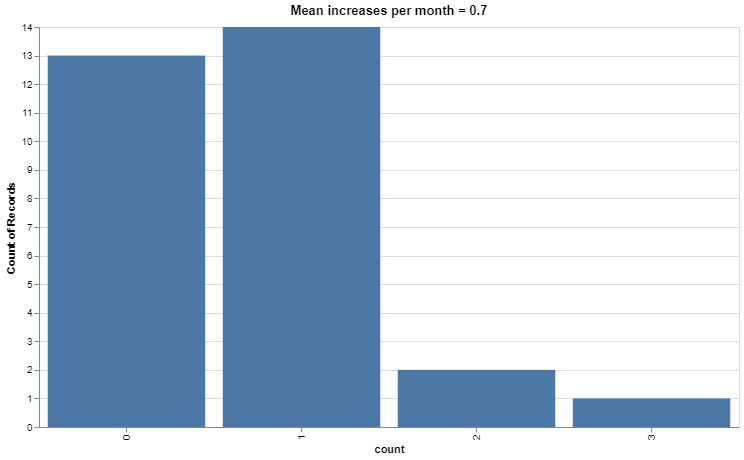

In [11]:
days_df = filtered_df.groupby(pd.Grouper(key="dt", freq="M")).agg("count")["units"].reset_index().rename(columns={"units": "count"})
alt.Chart(days_df).mark_bar(point=True) \
.encode(
    x = alt.X("count:N"),
    y = alt.Y("count()"),
).properties(width=700, height=400, title=f"Mean increases per month = {days_df['count'].mean()}")

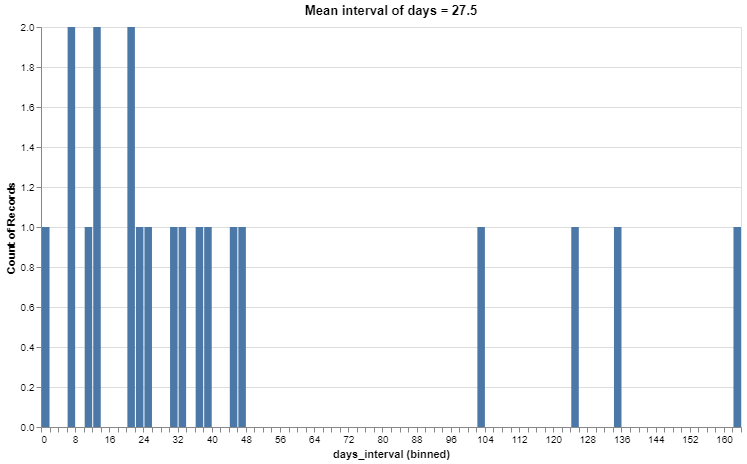

In [12]:
alt.Chart(filtered_df).mark_bar(point=True) \
.encode(
    x = alt.X("days_interval:Q", bin=alt.Bin(maxbins=100)),
    y = alt.Y("count()"),
).properties(width=700, height=400, title=f"Mean interval of days = {filtered_df['days_interval'].median()}")

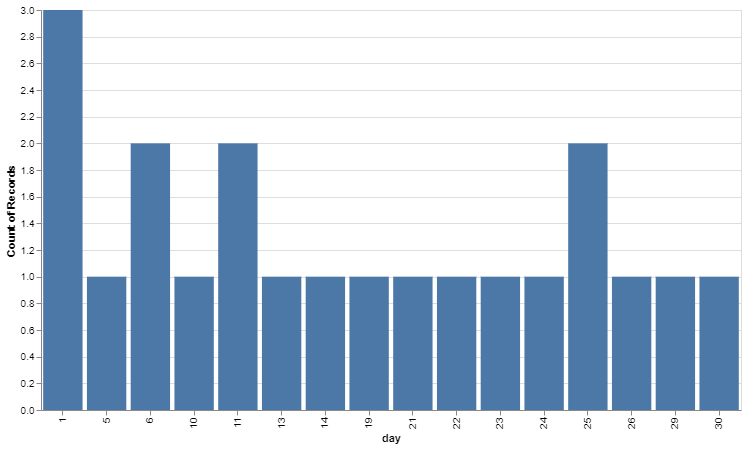

In [13]:
alt.Chart(filtered_df).mark_bar(point=True) \
.encode(
    x = alt.X("day:N"),
    y = alt.Y("count()"),
).properties(width=700, height=400)

### Save models

In [14]:
loc, scale = stats.expon.fit(filtered_df["new_inventory"])
print(f"Loc = {loc}; scale = {scale}")

Loc = 4373.0; scale = 3905.142857142857


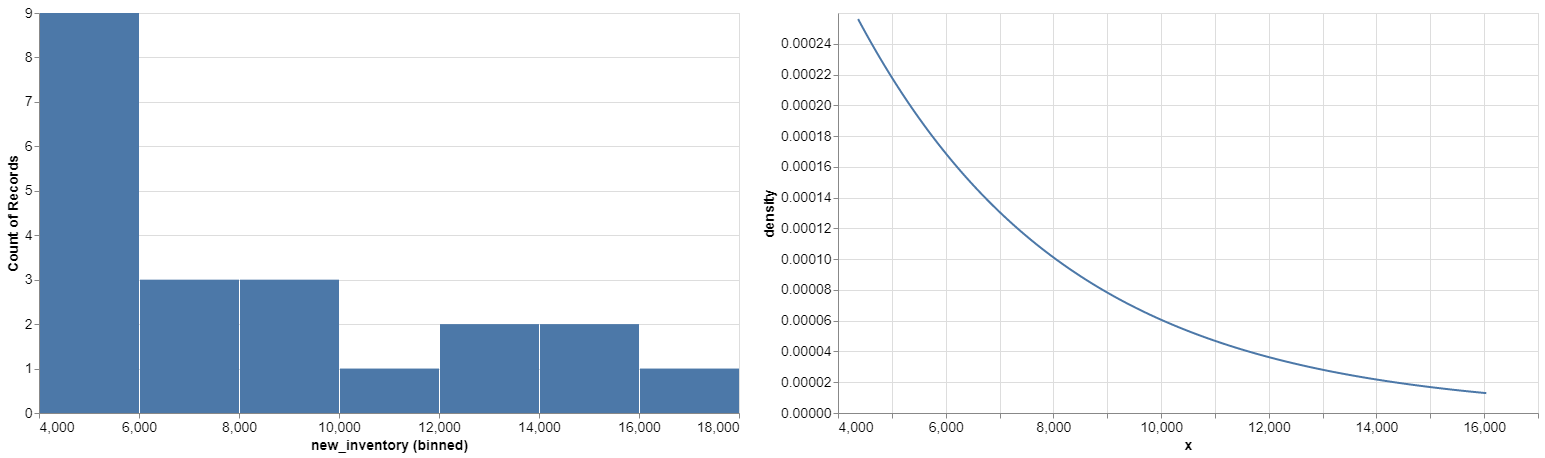

In [15]:
xt = np.linspace(filtered_df["new_inventory"].min(), filtered_df["new_inventory"].max(), 200)
density = stats.expon.pdf(xt, loc, scale)

density_chart = alt.Chart(pd.DataFrame({"x": xt, "density": density})).mark_line() \
.encode(
    x = alt.X("x:Q"),
    y = alt.Y("density:Q"),
).properties(width=700, height=400)

alt.ConcatChart(concat=[histogram, density_chart]).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)

In [76]:
zero_increase_probability = 0.3
days_per_month = 30
increase_probability = 1 - np.power(zero_increase_probability, 1 / days_per_month)
print(f"Probability of inventory increase = {increase_probability}")

Probability of inventory increase = 0.03933778670477284


In [77]:
np.save(os.path.join(models_path, "inventory_increase_parameters.npy"), np.array([increase_probability, loc, scale]))